***

## ***Jared Choy EG Intern Assessment***

***

In [88]:
# Packages

import pandas as pd
import numpy as np
import seaborn as sns
from dash import Dash, html, Input, Output, dash_table
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import random
from scipy import stats
from datetime import datetime
import time
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import kruskal
import calendar

In [91]:
df = pd.read_csv('/Users/fish/Documents/MISC/social_data.csv')

In [4]:
# Get an idea of what we're working with

display(df.head(5))

print(df.shape)

,Published Date,Account,Account Type,Campaign Name,Total Impressions,Total Engagements,Media Type
0,03-31-2023 19:55,CSGO,TWITTER,N/A,0,0,Text
1,03-31-2023 19:49,CSGO,TWITTER,N/A,0,0,Text
2,03-31-2023 19:49,CSGO,TWITTER,N/A,0,0,Text
3,03-31-2023 19:49,CSGO,TWITTER,N/A,0,0,Text
4,03-31-2023 19:43,CSGO,TWITTER,Community Engagement,9517,1215,Video


(3479, 7)


In [143]:
# Checking the unique values for dataframe to see if we need to clean

df['Account'].unique()

array(['CSGO', 'General ', 'DOTA2', 'Content Creators', 'Valorant',
       'General'], dtype=object)

In [145]:
df.loc[df['Account'] == 'General ', 'Account'] = 'General'

print(df['Account'].unique())

['CSGO' 'General' 'DOTA2' 'Content Creators' 'Valorant']


In [181]:
# Checking more to see if there's more columns we need to clean

display(df['Account Type'].unique())
display(df['Campaign Name'].unique()) # going to need to clean this
display(df['Media Type'].unique())

array(['TWITTER', 'FBPAGE', 'INSTAGRAM', 'TIKTOK_BUSINESS', 'YOUTUBE',
       'LINKEDIN_COMPANY'], dtype=object)

array(['N/A ', 'Community Engagement ', 'Evergreen ', 'Evil Exhibited '],
      dtype=object)

array(['Text', 'Video', 'Photo', 'Link', 'Carousel', 'Mixed', 'Album'],
      dtype=object)

In [182]:
# Remove spaces at the end of the column values
df['Campaign Name'] = df['Campaign Name'].str.strip()

In [183]:
# To check

display(df['Campaign Name'].unique())

array(['N/A', 'Community Engagement', 'Evergreen', 'Evil Exhibited'],
      dtype=object)

In [ ]:
# Print the latest and earliest dates
latest_date = df['Published Date'].max()
earliest_date = df['Published Date'].min()

print('Latest date:', latest_date)
print('Earliest date:', earliest_date)

Latest date: 2023-03-31 19:55:00
Earliest date: 2023-01-01 14:59:00


In [ ]:
# Print the most engagements observation

max_ob_id = df['Total Engagements'].idxmax()

ob_row = df.loc[max_ob_id]

display(ob_row)

Published Date       2023-01-10 14:32:00
Account                         General 
Account Type                      FBPAGE
Campaign Name                       N/A 
Total Impressions                 753227
Total Engagements                  95062
Media Type                         Video
Name: 3375, dtype: object

In [49]:
# Checking engagements and impressions

print("The total number of posts with zero engagements is:", df[df['Total Engagements'] == 0].shape[0])

print("The total number of posts with zero impressions is:", df[df['Total Impressions'] == 0].shape[0])

The total number of posts with zero engagements is: 966
The total number of posts with zero impressions is: 744


[]

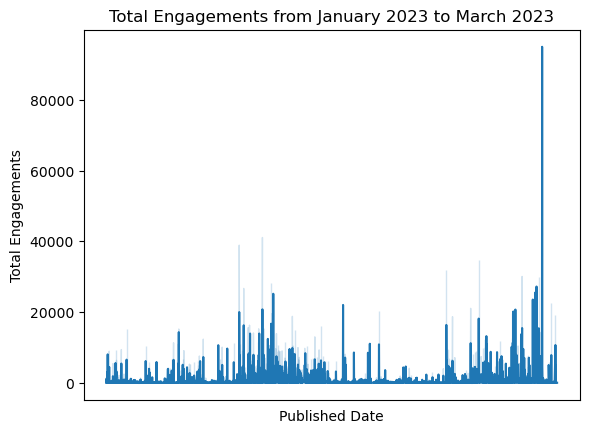

In [180]:
ax = sns.lineplot(x = "Published Date", y = "Total Engagements", data = df) # Graph with the titles
ax.set_title("Total Engagements from January 2023 to March 2023")
ax.set_xticks([])

[]

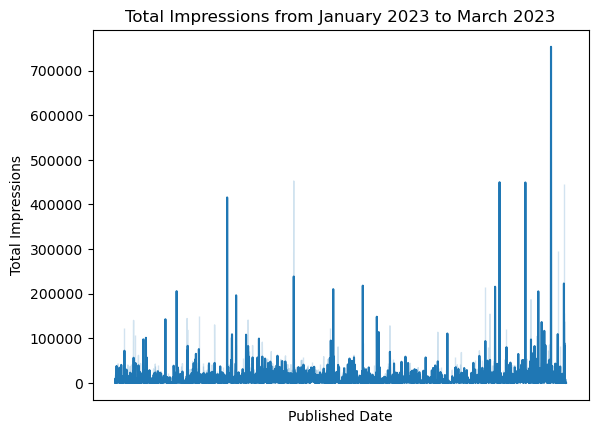

In [188]:
ax = sns.lineplot(x = "Published Date", y = "Total Impressions", data = df) # Graph with the titles
ax.set_title("Total Impressions from January 2023 to March 2023")
ax.set_xticks([])

In [29]:
# EDA Plotting
fig = px.box(df[df['Total Engagements'] < 80000] , x="Total Engagements", y="Media Type", color="Media Type", points = "all",
                 labels={
                     "Total Engagements": "Total Engagements",
                     "Media Type": "Media Type",
                 },
                title="Boxplot of Total Engagements for Each Media Type")
fig.show()

In [13]:
fig = px.scatter(df, 
                 x = 'Total Engagements',
                 y = 'Total Impressions',
                 template = 'plotly_dark',
                 color = 'Media Type',
                 trendline = 'ols',
                 title = 'Total Impressions and Total Engagements on Media Type')
fig.update_layout(showlegend=True)
fig.show()

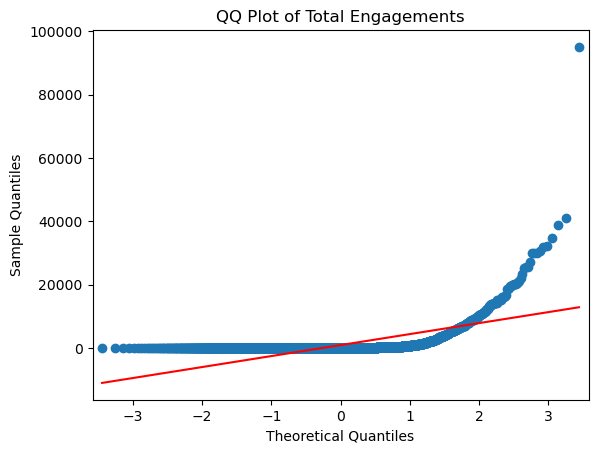

In [137]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot

# making a qqnorm plot of total engagements to assess normality

qqplot(df['Total Engagements'], line='s')

# Customize the plot if needed
plt.title('QQ Plot of Total Engagements')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')

plt.show()

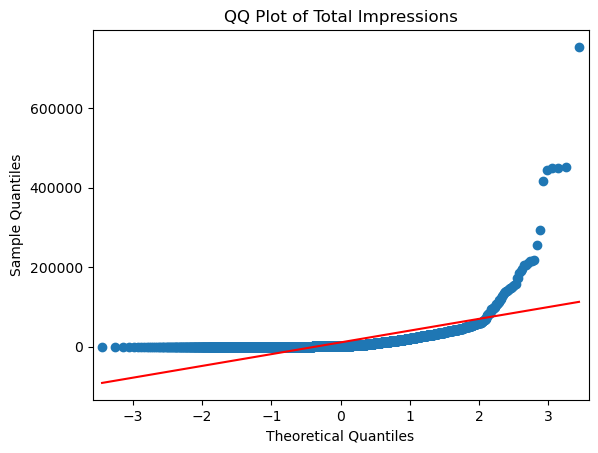

In [138]:
# qqnorm of the impressions

qqplot(df['Total Impressions'], line='s')

# Customize the plot if needed
plt.title('QQ Plot of Total Impressions')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')

plt.show()

##### From the plots we have seen, it's important to note that we aren't able to hold the normality assumptions under this data. As the non-normality of the data is important in the analysis of engagement, I instead choose to use non-parametric tests that don't need to satisfy the assumptions of normality. These tests include the Kruskal-Wallis, and Tukey pairwise difference tests for measuring disorder within groups. I find this to be highly useful, as we can first see if there are general differences between the groups, and then find which groups are specifically different.

#### The hypothesis for these tests are as follows:


$H_o: M_0 = ... = M_k$ vs. $H_a:$ At least one $M$ is not equivalent

$H_o: \mu_0 = \mu_1$ vs. $H_a:$ At least one $\mu$ is not equal

##### I used subsets for the plots above i.e. only using observations where engagements were less than 80,000, so that I could better show the graph. This is just to help visualize it, as there was a large outlier that made it difficult to read the graph. To better see the means and descriptive statistics, let's use `describe()` to obtain them.

In [190]:
df.columns

Index(['Published Date', 'Account', 'Account Type', 'Campaign Name',
       'Total Impressions', 'Total Engagements', 'Media Type',
       'Engagement Rate', 'Day of Week', 'Time of Post'],
      dtype='object')

In [191]:
# Going by account

display(df.groupby('Media Type')['Total Engagements'].describe())

display(df.groupby('Media Type')['Total Impressions'].describe())

,count,mean,std,min,25%,50%,75%,max
Media Type,,,,,,,,
Album,4.0,2.000000,4.000000,0.0,0.0,0.0,2.00,8.0
Carousel,9.0,726.777778,618.686669,123.0,327.0,528.0,894.00,2144.0
Link,94.0,24.010638,52.201737,0.0,0.0,0.0,22.25,336.0
Mixed,5.0,2732.800000,2896.540126,373.0,861.0,1040.0,4268.00,7122.0
Photo,1490.0,1454.858389,3959.888596,0.0,0.0,108.5,629.75,41102.0
Text,910.0,270.672527,1564.240188,0.0,0.0,5.0,35.75,29860.0
Video,967.0,888.780765,3983.874093,0.0,9.0,65.0,328.50,95062.0


,count,mean,std,min,25%,50%,75%,max
Media Type,,,,,,,,
Album,4.0,5.000000,10.000000,0.0,0.0,0.0,5.00,20.0
Carousel,9.0,17854.333333,7319.563904,8380.0,13062.0,17411.0,23121.00,29416.0
Link,94.0,2473.031915,4981.970516,0.0,0.0,0.0,1901.75,26091.0
Mixed,5.0,36996.800000,42462.775194,2028.0,6900.0,13178.0,64614.00,98264.0
Photo,1490.0,16036.236242,31467.186576,0.0,1053.0,5937.5,20680.25,452337.0
Text,910.0,3413.409890,16433.813132,0.0,0.0,262.0,1349.75,415457.0
Video,967.0,10956.373320,35413.244455,0.0,504.5,2441.0,11101.50,753227.0


In [192]:
# Going by Account Type

display(df.groupby('Account Type')['Total Engagements'].describe())

display(df.groupby('Account Type')['Total Impressions'].describe())

,count,mean,std,min,25%,50%,75%,max
Account Type,,,,,,,,
FBPAGE,585.0,4405.613675,7317.270756,0.0,0.00,1687.0,5994.0,95062.0
INSTAGRAM,588.0,143.005102,538.534299,0.0,0.00,0.0,6.0,5472.0
LINKEDIN_COMPANY,22.0,38.590909,37.700144,0.0,16.25,28.5,41.5,133.0
TIKTOK_BUSINESS,113.0,166.946903,939.566065,0.0,11.00,40.0,83.0,9680.0
TWITTER,1951.0,309.871348,974.696962,0.0,9.00,51.0,223.5,12348.0
YOUTUBE,220.0,46.945455,299.680190,0.0,0.00,9.5,35.0,4388.0


,count,mean,std,min,25%,50%,75%,max
Account Type,,,,,,,,
FBPAGE,585.0,24740.423932,39119.551336,0.0,0.00,19872.0,35237.00,753227.0
INSTAGRAM,588.0,6078.331633,11855.845721,0.0,0.00,3800.5,7431.00,172597.0
LINKEDIN_COMPANY,22.0,1945.500000,1086.290532,888.0,1164.75,1648.0,2215.50,5270.0
TIKTOK_BUSINESS,113.0,3045.654867,18599.114344,0.0,288.00,659.0,1313.00,196070.0
TWITTER,1951.0,9995.179908,30932.154371,0.0,423.00,1649.0,10560.00,452337.0
YOUTUBE,220.0,1083.650000,4570.975006,0.0,0.00,306.0,971.75,64879.0


In [193]:
# Going by Campaign Name

display(df.groupby('Campaign Name')['Total Engagements'].describe())

display(df.groupby('Campaign Name')['Total Impressions'].describe())

,count,mean,std,min,25%,50%,75%,max
Campaign Name,,,,,,,,
Community Engagement,1411.0,1449.161588,3725.507267,0.0,31.0,166.0,787.50,41102.0
Evergreen,163.0,264.582822,881.801557,0.0,15.5,46.0,138.50,8074.0
Evil Exhibited,420.0,441.202381,1397.704719,0.0,6.0,35.0,206.25,11048.0
N/A,1485.0,688.736027,3734.126476,0.0,0.0,0.0,54.00,95062.0


,count,mean,std,min,25%,50%,75%,max
Campaign Name,,,,,,,,
Community Engagement,1411.0,16870.131821,31292.897451,0.0,2085.00,9414.0,21069.00,452337.0
Evergreen,163.0,8151.711656,19178.447022,0.0,375.00,1134.0,10473.50,172597.0
Evil Exhibited,420.0,13672.845238,40549.519445,0.0,463.25,2433.5,12205.25,449596.0
N/A,1485.0,4914.536027,23295.965911,0.0,0.00,170.0,1857.00,753227.0


##### From the preliminary stats, we can make a lot of inferential predictions regarding the engagement and retention of viewers. From my point of view, we want a lot of engagements over everything. A large amount of impressions is terrific, but if we see no engagement than what is the point. Engagement is how EG can cultivate a fanatic-following, that will continuously support the brand. 

##### This starts with the way EG approaches content, and also advertising. As I delve deeper into the workings of EG's social media usage and content outreach, I hope to come up with a plan to cultivate a dedicated fanbase. 

In [ ]:
# Print the latest and earliest dates
latest_date = df['Published Date'].max()
earliest_date = df['Published Date'].min()

print('Latest date:', latest_date)
print('Earliest date:', earliest_date)

Latest date: 2023-03-31 19:55:00
Earliest date: 2023-01-01 14:59:00


In [ ]:
# Print the most engagements observation

max_ob_id = df['Total Engagements'].idxmax()

ob_row = df.loc[max_ob_id]

display(ob_row)

Published Date       2023-01-10 14:32:00
Account                         General 
Account Type                      FBPAGE
Campaign Name                       N/A 
Total Impressions                 753227
Total Engagements                  95062
Media Type                         Video
Name: 3375, dtype: object

***

## **What is the typical engagement rate we can expect? What’s the likelihood that we can achieve a 15% engagement rate?**

***

In [34]:
print("The average total engagements per media is:", df['Total Engagements'].mean())

The average total engagements per media is: 947.3906294912331


On average, we can expect any given post to receive approximately 947 engagements total. This is not terrible, but recall that we do have a pretty sizable outlier in our dataset. Let's see what this total might look like without that outlier.

In [39]:
# Getting rid of the outlier
scaled = df[df['Total Engagements'] < 80000]

print("The average total engagements per media is:", scaled['Total Engagements'].mean())

The average total engagements per media is: 920.330649798735


We still have a decent number of total engagements, but let's try and find the actual engagement rate now. To do this, we will be utilizing the total impressions as well.

In [92]:
# Engagements/Impressions to calculate a rate for each observation

df['Engagement Rate'] = (df['Total Engagements'] / df['Total Impressions']) * 100

# Replace NaN with 0 as, 0/0 will give the NaN error
df['Engagement Rate'] = df['Engagement Rate'].fillna(0)

# Heading 5 to show output
df.head(5)

,Published Date,Account,Account Type,Campaign Name,Total Impressions,Total Engagements,Media Type,Engagement Rate
0,03-31-2023 19:55,CSGO,TWITTER,N/A,0,0,Text,0.000000
1,03-31-2023 19:49,CSGO,TWITTER,N/A,0,0,Text,0.000000
2,03-31-2023 19:49,CSGO,TWITTER,N/A,0,0,Text,0.000000
3,03-31-2023 19:49,CSGO,TWITTER,N/A,0,0,Text,0.000000
4,03-31-2023 19:43,CSGO,TWITTER,Community Engagement,9517,1215,Video,12.766628


In [73]:
display(df.sort_values(by='Engagement Rate', ascending=False))

,Published Date,Account,Account Type,Campaign Name,Total Impressions,Total Engagements,Media Type,Engagement Rate
837,2023-03-10 12:37:00,General,FBPAGE,N/A,1,940,Photo,94000.000000
3457,2023-01-05 11:55:00,General,FBPAGE,N/A,300,3776,Photo,1258.666667
3216,2023-01-19 06:02:00,General,FBPAGE,N/A,5,44,Photo,880.000000
1586,2023-02-23 06:18:00,General,FBPAGE,N/A,1,1,Photo,100.000000
2361,2023-02-09 15:00:00,General,TWITTER,N/A,55,33,Link,60.000000
...,...,...,...,...,...,...,...,...
1985,2023-02-15 11:42:00,General,INSTAGRAM,Evil Exhibited,2193,0,Photo,0.000000
1984,2023-02-15 11:42:00,General,INSTAGRAM,N/A,0,0,Photo,0.000000
1983,2023-02-15 11:42:00,General,INSTAGRAM,N/A,0,0,Photo,0.000000
1982,2023-02-15 11:42:00,General,INSTAGRAM,N/A,0,0,Photo,0.000000


An engagement rate of 949999% doesn't make a whole lot of sense, so let's recode this.

In [93]:
df['Engagement Rate'] = df['Engagement Rate'].clip(upper=1)

df[df['Engagement Rate'] == 1].shape[0]

2256

In [80]:
# Now calculating actual engagement rate average

print("The average engagement rate per media post is:", df['Engagement Rate'].mean())

The average engagement rate per media post is: 0.6979024944714242


From our calculations, the expected value of our engagement rate is 31.83 percent. Let's now calculate the likelihood we can achieve a 15% engagement rate.

In [81]:
# Setting threshold to .15

rows15p = len(df[df['Engagement Rate'] >= .15])

# Calculate the likelihood

print("The likelihood we achieve at least a 15% engagement rate is:", rows15p / df.shape[0])

The likelihood we achieve at least a 15% engagement rate is: 0.7214716872664558


***

## **Does day of the week and time of posting affect engagement rates?**

***

In [94]:
# Convert the date it was posted to get the specific day

df['Day of Week'] = pd.to_datetime(df['Published Date']).dt.day_name()

df.head(5)

,Published Date,Account,Account Type,Campaign Name,Total Impressions,Total Engagements,Media Type,Engagement Rate,Day of Week
0,03-31-2023 19:55,CSGO,TWITTER,N/A,0,0,Text,0.0,Friday
1,03-31-2023 19:49,CSGO,TWITTER,N/A,0,0,Text,0.0,Friday
2,03-31-2023 19:49,CSGO,TWITTER,N/A,0,0,Text,0.0,Friday
3,03-31-2023 19:49,CSGO,TWITTER,N/A,0,0,Text,0.0,Friday
4,03-31-2023 19:43,CSGO,TWITTER,Community Engagement,9517,1215,Video,1.0,Friday


In [86]:
# Display calendar for the year 2023 to check if our new column is correct
print(calendar.calendar(2023))

                                  2023

      January                   February                   March
Mo Tu We Th Fr Sa Su      Mo Tu We Th Fr Sa Su      Mo Tu We Th Fr Sa Su
                   1             1  2  3  4  5             1  2  3  4  5
 2  3  4  5  6  7  8       6  7  8  9 10 11 12       6  7  8  9 10 11 12
 9 10 11 12 13 14 15      13 14 15 16 17 18 19      13 14 15 16 17 18 19
16 17 18 19 20 21 22      20 21 22 23 24 25 26      20 21 22 23 24 25 26
23 24 25 26 27 28 29      27 28                     27 28 29 30 31
30 31

       April                      May                       June
Mo Tu We Th Fr Sa Su      Mo Tu We Th Fr Sa Su      Mo Tu We Th Fr Sa Su
                1  2       1  2  3  4  5  6  7                1  2  3  4
 3  4  5  6  7  8  9       8  9 10 11 12 13 14       5  6  7  8  9 10 11
10 11 12 13 14 15 16      15 16 17 18 19 20 21      12 13 14 15 16 17 18
17 18 19 20 21 22 23      22 23 24 25 26 27 28      19 20 21 22 23 24 25
24 25 26 27 28 29 30      

The output lines up with the calendar, so let's try and convert each publish date to the time of day it was posted in.

In [121]:
# Writing function to be able to classfiy

def time_class(time):
    if time.hour < 4:
        return 'Early Morning' # Before noon is morning
    elif time.hour >= 4 and time.hour < 12: 
        return 'Morning'
    elif time.hour >= 12 and time.hour < 2: # Noon to 2, let's just call it noon
        return 'Noon'
    elif time.hour >= 2 and time.hour < 6:
        return 'Afternoon'
    else:
        return 'Nighttime'

df['Time of Post'] = pd.to_datetime(df['Published Date']).dt.time.apply(time_class)

df.head(5)

print(df['Day of Week'].unique())
print(df['Time of Post'].unique())

['Friday' 'Thursday' 'Wednesday' 'Tuesday' 'Monday' 'Sunday' 'Saturday']
['Nighttime' 'Morning' 'Early Morning']


We've now classified the time of post, so let's try and see how each of the days perform. 

In [115]:
# Engagements by Day of Week

fig = px.scatter(df[df['Total Engagements'] < 80000], 
                 x = 'Total Engagements',
                 y = 'Total Impressions',
                 template = 'plotly_dark',
                 color = 'Day of Week',
                 trendline = 'ols',
                 title = 'Total Engagements and Total Impressions on Day of Week')
fig.update_layout(showlegend=True)
fig.show()

In [206]:
# Going by time of post

display(df.groupby('Day of Week')['Total Engagements'].describe())

display(df.groupby('Day of Week')['Total Impressions'].describe())

display(df.groupby('Day of Week')['Engagement Rate'].describe())

,count,mean,std,min,25%,50%,75%,max
Day of Week,,,,,,,,
Friday,708.0,907.621469,3027.494157,0.0,2.00,48.0,331.50,38921.0
Monday,234.0,710.594017,2914.323581,0.0,2.25,36.0,141.25,29860.0
Saturday,319.0,459.855799,1601.826382,0.0,0.00,37.0,182.00,16777.0
Sunday,376.0,1051.808511,3111.292438,0.0,0.00,31.0,319.50,31855.0
Thursday,706.0,1083.456091,3315.690428,0.0,0.00,51.0,364.00,30005.0
Tuesday,561.0,1303.898396,5223.733534,0.0,0.00,43.0,371.00,95062.0
Wednesday,575.0,780.027826,3155.062546,0.0,0.00,22.0,191.50,41102.0


,count,mean,std,min,25%,50%,75%,max
Day of Week,,,,,,,,
Friday,708.0,10566.543785,22559.094147,0.0,341.75,2569.0,13936.25,415457.0
Monday,234.0,10581.320513,24941.585668,0.0,184.75,1297.5,10594.50,209875.0
Saturday,319.0,9493.708464,27977.057334,0.0,336.00,2463.0,12680.50,452337.0
Sunday,376.0,9923.795213,17605.015999,0.0,0.00,1826.0,13210.25,204908.0
Thursday,706.0,12071.818697,31692.558243,0.0,261.50,2105.0,12610.25,449052.0
Tuesday,561.0,12828.923351,44097.014942,0.0,103.00,1786.0,11252.00,753227.0
Wednesday,575.0,9976.441739,25423.754505,0.0,0.00,1450.0,9992.00,256502.0


,count,mean,std,min,25%,50%,75%,max
Day of Week,,,,,,,,
Friday,708.0,0.740441,0.425047,0.0,0.506528,1.0,1.0,1.0
Monday,234.0,0.738579,0.421266,0.0,0.479198,1.0,1.0,1.0
Saturday,319.0,0.652627,0.443805,0.0,0.000000,1.0,1.0,1.0
Sunday,376.0,0.641517,0.470436,0.0,0.000000,1.0,1.0,1.0
Thursday,706.0,0.715633,0.443449,0.0,0.000000,1.0,1.0,1.0
Tuesday,561.0,0.709458,0.445352,0.0,0.000000,1.0,1.0,1.0
Wednesday,575.0,0.657917,0.457435,0.0,0.000000,1.0,1.0,1.0


In [196]:
# Doing day of week
groups = {}

for group in df["Day of Week"].unique():
    groups[group] = df.loc[df['Day of Week'] == group, 'Total Impressions'].values

# Perform Kruskal-Wallis test
statistic, p_value = kruskal(*groups.values())

print("Kruskal-Wallis test statistic:", statistic)
print("p-value:", p_value)

Kruskal-Wallis test statistic: 18.787848895935873
p-value: 0.004537337299794104


In [201]:
# Going to look at days first
days = list(calendar.day_name)

# creating a function that performs a Tukey pairwise difference test for difference of means
def tukey_table(variable):
    gen_title = "Tukey Table for Comparisons of "
    fig = go.Figure(data=[go.Table(
    header=dict(values=list(tukey_sum.columns),
                fill_color='lavenderblush',
                align='left'),
    cells=dict(values=[tukey_sum.group1, tukey_sum.group2, tukey_sum.meandiff, tukey_sum['p-adj'], tukey_sum.lower, tukey_sum.upper, tukey_sum.reject],
               fill_color='lavender',
               align='left'))
    ])
    fig.update_layout(
    title_text = gen_title + variable,
    title_x=0.5,
    title_font_size=30,
    font_family="Times New Roman",
    font_color="black",
    title_font_family="Times New Roman",
    title_font_color="black",
    )
    fig.update_traces(cells_font=dict(size = 10))
    fig.show()

def tukey_grab(frame, variable, calend):
    comp = []
    bank = []
    for i in days:
        x = list(frame[frame[calend] == i][variable])
        comp = x + comp
        y = list(np.repeat([i], repeats = len(x)))
        bank = y + bank
    # Creating df for our list of rates and eths
    diff_frame = pd.DataFrame({variable: comp, calend: bank}) 

    # actual tukey test
    tukey = pairwise_tukeyhsd(endog=diff_frame[variable].rank(), # USED RANK FOR NONPARAMETRIC
                          groups=diff_frame[calend],
                          alpha=0.05)
    global tukey_sum # Need to make it global so it works on the other function
    tukey_sum = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])
    tukey_table(variable)
    
    print(tukey)
    # Convert to dataframe for figure

In [117]:
tukey_grab(df, 'Total Engagements', 'Day of Week')

     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
 group1    group2   meandiff p-adj    lower    upper   reject
-------------------------------------------------------------
  Friday    Monday -122.6556 0.6557 -343.1864  97.8751  False
  Friday  Saturday -159.6928 0.2035 -356.9085  37.5229  False
  Friday    Sunday -116.5168 0.5196 -303.1428  70.1093  False
  Friday  Thursday   -16.629 0.9999 -172.1804 138.9224  False
  Friday   Tuesday  -26.7301 0.9991 -192.0408 138.5806  False
  Friday Wednesday -208.9617 0.0033 -373.1458 -44.7777   True
  Monday  Saturday  -37.0372 0.9995 -288.7628 214.6885  False
  Monday    Sunday    6.1389    1.0 -237.3792  249.657  False
  Monday  Thursday  106.0266 0.7924 -114.5817 326.6349  False
  Monday   Tuesday   95.9255 0.8771 -131.6693 323.5204  False
  Monday Wednesday  -86.3061 0.9213 -313.0839 140.4718  False
Saturday    Sunday   43.1761 0.9976 -179.4476 265.7997  False
Saturday  Thursday  143.0638 0.3298  -54.2386 340.3662  False
Saturday

In [118]:
tukey_grab(df, 'Total Impressions', 'Day of Week')

     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
 group1    group2   meandiff p-adj    lower    upper   reject
-------------------------------------------------------------
  Friday    Monday -160.7181 0.3314  -382.651  61.2148  False
  Friday  Saturday  -40.9705 0.9966 -239.4402 157.4991  False
  Friday    Sunday -104.4767 0.6555 -292.2894  83.3359  False
  Friday  Thursday  -30.6457 0.9974 -187.1861 125.8947  False
  Friday   Tuesday -103.5529 0.5234 -269.9147  62.8089  False
  Friday Wednesday -212.0255  0.003 -377.2534 -46.7975   True
  Monday  Saturday  119.7475  0.805 -133.5787 373.0737  False
  Monday    Sunday   56.2413 0.9938 -188.8251 301.3078  False
  Monday  Thursday  130.0724 0.5969  -91.9386 352.0834  False
  Monday   Tuesday   57.1652 0.9903 -171.8768 286.2071  False
  Monday Wednesday  -51.3074 0.9945 -279.5271 176.9124  False
Saturday    Sunday  -63.5062 0.9812 -287.5454  160.533  False
Saturday  Thursday   10.3248    1.0 -188.2321 208.8818  False
Saturday

In [202]:
tukey_grab(df, 'Engagement Rate', 'Day of Week')

     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
 group1    group2   meandiff p-adj    lower    upper   reject
-------------------------------------------------------------
  Friday    Monday   -9.8454    1.0 -197.0801 177.3893  False
  Friday  Saturday -180.7211 0.0247 -348.1609 -13.2814   True
  Friday    Sunday -152.8378  0.067 -311.2867   5.6112  False
  Friday  Thursday  -16.1659 0.9998  -148.232 115.9001  False
  Friday   Tuesday  -34.0681 0.9917   -174.42 106.2837  False
  Friday Wednesday -150.6237 0.0244  -290.019 -11.2284   True
  Monday  Saturday -170.8757 0.2167 -384.5955   42.844  False
  Monday    Sunday -142.9923 0.3892 -349.7437  63.7591  False
  Monday  Thursday   -6.3205    1.0 -193.6211   180.98  False
  Monday   Tuesday  -24.2227 0.9998  -217.455 169.0095  False
  Monday Wednesday -140.7783 0.3195 -333.3169  51.7603  False
Saturday    Sunday   27.8834 0.9995 -161.1282  216.895  False
Saturday  Thursday  164.5552  0.058   -2.9582 332.0686  False
Saturday

In [199]:
# Going to look at time of day now
times = df['Time of Post'].unique()

# creating a function that performs a Tukey pairwise difference test for difference of means
def tukey_table(variable):
    gen_title = "Tukey Table for Comparisons of "
    fig = go.Figure(data=[go.Table(
    header=dict(values=list(tukey_sum.columns),
                fill_color='lavenderblush',
                align='left'),
    cells=dict(values=[tukey_sum.group1, tukey_sum.group2, tukey_sum.meandiff, tukey_sum['p-adj'], tukey_sum.lower, tukey_sum.upper, tukey_sum.reject],
               fill_color='lavender',
               align='left'))
    ])
    fig.update_layout(
    title_text = gen_title + variable,
    title_x=0.5,
    title_font_size=30,
    font_family="Times New Roman",
    font_color="black",
    title_font_family="Times New Roman",
    title_font_color="black",
    )
    fig.update_traces(cells_font=dict(size = 10))
    fig.show()

def tukey_grab(frame, variable, calend):
    comp = []
    bank = []
    for i in times:
        x = list(frame[frame[calend] == i][variable])
        comp = x + comp
        y = list(np.repeat([i], repeats = len(x)))
        bank = y + bank
    # Creating df for our list of rates and eths
    diff_frame = pd.DataFrame({variable: comp, calend: bank}) 

    # actual tukey test
    tukey = pairwise_tukeyhsd(endog=diff_frame[variable].rank(), # USED RANK FOR NONPARAMETRIC
                          groups=diff_frame[calend],
                          alpha=0.05)
    global tukey_sum # Need to make it global so it works on the other function
    tukey_sum = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])
    tukey_table(variable)
    
    print(tukey)
    # Convert to dataframe for figure

In [130]:
tukey_grab(df, 'Total Engagements', 'Time of Post')

        Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1      group2   meandiff p-adj    lower     upper   reject
-------------------------------------------------------------------
Early Morning   Morning -463.5282 0.3862 -1289.3284 362.2719  False
Early Morning Nighttime -507.0374 0.3201 -1332.1711 318.0963  False
      Morning Nighttime  -43.5092 0.4116  -123.7603   36.742  False
-------------------------------------------------------------------


In [126]:
tukey_grab(df, 'Total Impressions', 'Time of Post')

        Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1      group2   meandiff p-adj    lower     upper   reject
-------------------------------------------------------------------
Early Morning   Morning -445.4732 0.4197 -1276.3153 385.3689  False
Early Morning Nighttime -413.1378 0.4731 -1243.3093 417.0337  False
      Morning Nighttime   32.3354 0.6156   -48.4057 113.0765  False
-------------------------------------------------------------------


In [200]:
# For engagement rate

tukey_grab(df, 'Engagement Rate', 'Time of Post')

       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1      group2   meandiff p-adj    lower    upper   reject
------------------------------------------------------------------
Early Morning   Morning -225.1239 0.7323 -926.7964 476.5486  False
Early Morning Nighttime -231.2554 0.7194 -932.3617 469.8508  False
      Morning Nighttime   -6.1315 0.9758  -74.3199  62.0569  False
------------------------------------------------------------------


In [198]:
# Going by time of post

display(df.groupby('Time of Post')['Total Engagements'].describe())

display(df.groupby('Time of Post')['Total Impressions'].describe())

display(df.groupby('Time of Post')['Engagement Rate'].describe())

,count,mean,std,min,25%,50%,75%,max
Time of Post,,,,,,,,
Early Morning,8.0,673.500000,1028.969248,0.0,81.5,162.5,770.25,2408.0
Morning,1439.0,1070.656011,3296.987200,0.0,0.0,43.0,342.50,41102.0
Nighttime,2032.0,861.176181,3589.533044,0.0,0.0,36.0,249.25,95062.0


,count,mean,std,min,25%,50%,75%,max
Time of Post,,,,,,,,
Early Morning,8.0,12340.750000,12582.702682,0.0,2240.25,8586.5,19989.75,32613.0
Morning,1439.0,12365.214038,33998.096522,0.0,91.50,1820.0,12210.00,452337.0
Nighttime,2032.0,9980.756398,26014.786162,0.0,205.75,1928.0,12782.25,753227.0


,count,mean,std,min,25%,50%,75%,max
Time of Post,,,,,,,,
Early Morning,8.0,0.855019,0.349979,0.0,0.960039,1.0,1.0,1.0
Morning,1439.0,0.695089,0.449633,0.0,0.000000,1.0,1.0,1.0
Nighttime,2032.0,0.699277,0.442377,0.0,0.000000,1.0,1.0,1.0


##### Our results emphasized how there wasn't a huge difference generally, in the days of the week that a post was made on. However, one day did see a wider range of disparity from the others. The only times we rejected our Kruskal-Wallis null hypothesis for equivalent means, was Wednesday. We observed that we could reject the means for Friday-Wednesday, Thursday-Wednesday, and Tuesday-Wednesday when looking at engagements. For impressions, this was also true except we did not reject on Tuesday-Wednesday. And from our summary table from before, it might be better to post on weekdays. It is interesting to note that from the graphs, Wednesday sees a lot of higher engagement, which appear to be outliers. I surmise that a weekday announcement or content piece will stand out more than on Saturday when we typically see matches being played. Which might mean that some posts just get drowned out. This also follows as our engagement rates on Fridays were much different than Wednesday and Saturday.

##### Looking at the time of post now, we saw that there wasn't a huge difference for the time when the post went out for any of the three categories. So it's probably best to post off of other brands, and when they aren't posting anything huge. 

***

## **How are our game titles doing in terms of social performance? Is there a specific game we should focus more on or less?**

***

In [146]:
# Engagements by Game Titles

fig = px.scatter(df[df['Total Engagements'] < 80000], 
                 x = 'Total Engagements',
                 y = 'Total Impressions',
                 template = 'plotly_dark',
                 color = 'Account',
                 trendline = 'ols',
                 title = 'Total Engagements and Total Impressions on Game Title')
fig.update_layout(showlegend=True)
fig.show()

In [147]:
# Engagements by Day of Week

fig = px.scatter(df[df['Total Engagements'] < 20000], 
                 x = 'Total Engagements',
                 y = 'Total Impressions',
                 template = 'plotly_dark',
                 color = 'Account',
                 trendline = 'ols',
                 title = 'Total Engagements and Total Impressions on Game Title')
fig.update_layout(showlegend=True)
fig.show()

In [207]:
# Looking at the means of total impressions and engagements

display(df.groupby('Account')['Total Impressions'].describe())

display(df.groupby('Account')['Total Engagements'].describe())

display(df.groupby('Account')['Engagement Rate'].describe())

,count,mean,std,min,25%,50%,75%,max
Account,,,,,,,,
CSGO,270.0,8570.066667,36832.498876,0.0,0.0,1501.5,3276.00,445130.0
Content Creators,53.0,852.566038,1245.170663,0.0,0.0,150.0,1676.00,5685.0
DOTA2,803.0,2315.474471,4621.612974,0.0,395.5,999.0,2412.50,64879.0
General,2293.0,14797.975142,33373.619285,0.0,170.0,5318.0,18845.00,753227.0
Valorant,60.0,382.983333,1598.664522,0.0,0.0,27.0,300.75,12320.0


,count,mean,std,min,25%,50%,75%,max
Account,,,,,,,,
CSGO,270.0,341.985185,1162.159415,0.0,0.0,23.5,113.00,10909.0
Content Creators,53.0,26.169811,33.082494,0.0,0.0,11.0,45.00,130.0
DOTA2,803.0,154.408468,381.868036,0.0,7.0,34.0,131.00,4465.0
General,2293.0,1342.053205,4193.532997,0.0,0.0,57.0,477.00,95062.0
Valorant,60.0,15.516667,60.028381,0.0,0.0,1.5,13.25,463.0


,count,mean,std,min,25%,50%,75%,max
Account,,,,,,,,
CSGO,270.0,0.722650,0.440173,0.0,0.0,1.0,1.0,1.0
Content Creators,53.0,0.641509,0.484146,0.0,0.0,1.0,1.0,1.0
DOTA2,803.0,0.844966,0.350362,0.0,1.0,1.0,1.0,1.0
General,2293.0,0.649533,0.460705,0.0,0.0,1.0,1.0,1.0
Valorant,60.0,0.516667,0.503939,0.0,0.0,1.0,1.0,1.0


In [151]:
# Boxplot of each account, subsetting under 20000 so you can get a better idea

fig = px.box(df[df['Total Engagements'] < 20000] , x="Total Engagements", y="Account", color="Account", points = "all",
                 labels={
                     "Total Engagements": "Total Engagements",
                     "Account": "Account",
                 },
                title="Boxplot of Total Engagements for Each Game Title")
fig.show()

In [194]:
# Create an empty dictionary to store the groups
groups = {}

# Iterate over unique values in 'group_column' and store the corresponding values from 'column_to_test'
for group in df["Account"].unique():
    groups[group] = df.loc[df['Account'] == group, 'Total Impressions'].values

# Perform Kruskal-Wallis test
statistic, p_value = kruskal(*groups.values())

print("Kruskal-Wallis test statistic:", statistic)
print("p-value:", p_value)

Kruskal-Wallis test statistic: 270.30567619730925
p-value: 2.7409107790763434e-57


In [208]:
# Create an empty dictionary to store the groups
groups = {}

# Iterate over unique values in 'group_column' and store the corresponding values from 'column_to_test'
for group in df["Account"].unique():
    groups[group] = df.loc[df['Account'] == group, 'Total Engagements'].values

# Perform Kruskal-Wallis test
statistic, p_value = kruskal(*groups.values())

print("Kruskal-Wallis test statistic:", statistic)
print("p-value:", p_value)

Kruskal-Wallis test statistic: 68.67234031092129
p-value: 4.327232690045496e-14


In [209]:
# Create an empty dictionary to store the groups
groups = {}

# Iterate over unique values in 'group_column' and store the corresponding values from 'column_to_test'
for group in df["Account"].unique():
    groups[group] = df.loc[df['Account'] == group, 'Engagement Rate'].values

# Perform Kruskal-Wallis test
statistic, p_value = kruskal(*groups.values())

print("Kruskal-Wallis test statistic:", statistic)
print("p-value:", p_value)

Kruskal-Wallis test statistic: 132.8183952658596
p-value: 9.717869846962227e-28


In [203]:
# Going to look at time of day now
games = df['Account'].unique()

# creating a function that performs a Tukey pairwise difference test for difference of means
def tukey_table(variable):
    gen_title = "Tukey Table for Comparisons of "
    fig = go.Figure(data=[go.Table(
    header=dict(values=list(tukey_sum.columns),
                fill_color='lavenderblush',
                align='left'),
    cells=dict(values=[tukey_sum.group1, tukey_sum.group2, tukey_sum.meandiff, tukey_sum['p-adj'], tukey_sum.lower, tukey_sum.upper, tukey_sum.reject],
               fill_color='lavender',
               align='left'))
    ])
    fig.update_layout(
    title_text = gen_title + variable,
    title_x=0.5,
    title_font_size=30,
    font_family="Times New Roman",
    font_color="black",
    title_font_family="Times New Roman",
    title_font_color="black",
    )
    fig.update_traces(cells_font=dict(size = 10))
    fig.show()

def tukey_grab(frame, variable, calend):
    comp = []
    bank = []
    for i in games:
        x = list(frame[frame[calend] == i][variable])
        comp = x + comp
        y = list(np.repeat([i], repeats = len(x)))
        bank = y + bank
    # Creating df for our list of rates and eths
    diff_frame = pd.DataFrame({variable: comp, calend: bank}) 

    # actual tukey test
    tukey = pairwise_tukeyhsd(endog=diff_frame[variable].rank(), # USED RANK FOR NONPARAMETRIC
                          groups=diff_frame[calend],
                          alpha=0.05)
    global tukey_sum # Need to make it global so it works on the other function
    tukey_sum = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])
    tukey_table(variable)
    
    print(tukey)
    # Convert to dataframe for figure

In [204]:
# For engagement rate

tukey_grab(df, 'Total Engagements', 'Account')

             Multiple Comparison of Means - Tukey HSD, FWER=0.05              
     group1           group2       meandiff p-adj    lower      upper   reject
------------------------------------------------------------------------------
            CSGO Content Creators -382.2862 0.0733  -785.8961   21.3238  False
            CSGO            DOTA2   90.4992  0.687   -98.4916  279.4899  False
            CSGO          General  197.9988 0.0154    25.1482  370.8493   True
            CSGO         Valorant -660.9167    0.0 -1044.3412 -277.4922   True
Content Creators            DOTA2  472.7853 0.0064    91.7883  853.7824   True
Content Creators          General  580.2849 0.0002    207.031  953.5389   True
Content Creators         Valorant -278.6305 0.5615  -785.0449  227.7839  False
           DOTA2          General  107.4996 0.0597    -2.6597  217.6589  False
           DOTA2         Valorant -751.4158    0.0 -1110.9601 -391.8715   True
         General         Valorant -858.9154    0.0 -

In [205]:
tukey_grab(df, 'Total Impressions', 'Account')

             Multiple Comparison of Means - Tukey HSD, FWER=0.05              
     group1           group2       meandiff p-adj    lower      upper   reject
------------------------------------------------------------------------------
            CSGO Content Creators -457.6899 0.0133  -851.5044  -63.8754   True
            CSGO            DOTA2  -70.1234 0.8378  -254.5274  114.2807  False
            CSGO          General  442.1593    0.0   273.5037  610.8148   True
            CSGO         Valorant -748.0667    0.0 -1122.1856 -373.9477   True
Content Creators            DOTA2  387.5666 0.0361    15.8162  759.3169   True
Content Creators          General  899.8492    0.0    535.654 1264.0445   True
Content Creators         Valorant -290.3767  0.495  -784.5007  203.7472  False
           DOTA2          General  512.2827    0.0   404.7969  619.7684   True
           DOTA2         Valorant -677.9433    0.0 -1028.7616  -327.125   True
         General         Valorant -1190.226    0.0 -

##### From the results, the points of discussion we should focus on is VALORANT and content creators. The Valorant scores for impressions, engagements, and engagement rate is not anywhere it should be. Especially given that Valorant is the biggest game that EG currently participates in, and there is a lot of fans you can be making in the inagural season. With content creators, it's also important to note that there isn't really one star EG can claim to help them bolster these ratings. A content creator is extremely important to gain casual fans as well as generate more brand support. Hiring a content creator maybe in VALORANT could help the brand immensely.

##### From our results, we see that the long standing EG projects such as CS:GO and Dota are performing well, and this makes sense as they have established fanbases, and EG is one of two remaining large organizations in North American CS:GO. I think that anoth

***

## **What media type performs the best?**

***

In [210]:
# Looking at the means of total impressions and engagements

display(df.groupby('Media Type')['Total Impressions'].describe())

display(df.groupby('Media Type')['Total Engagements'].describe())

display(df.groupby('Media Type')['Engagement Rate'].describe())

,count,mean,std,min,25%,50%,75%,max
Media Type,,,,,,,,
Album,4.0,5.000000,10.000000,0.0,0.0,0.0,5.00,20.0
Carousel,9.0,17854.333333,7319.563904,8380.0,13062.0,17411.0,23121.00,29416.0
Link,94.0,2473.031915,4981.970516,0.0,0.0,0.0,1901.75,26091.0
Mixed,5.0,36996.800000,42462.775194,2028.0,6900.0,13178.0,64614.00,98264.0
Photo,1490.0,16036.236242,31467.186576,0.0,1053.0,5937.5,20680.25,452337.0
Text,910.0,3413.409890,16433.813132,0.0,0.0,262.0,1349.75,415457.0
Video,967.0,10956.373320,35413.244455,0.0,504.5,2441.0,11101.50,753227.0


,count,mean,std,min,25%,50%,75%,max
Media Type,,,,,,,,
Album,4.0,2.000000,4.000000,0.0,0.0,0.0,2.00,8.0
Carousel,9.0,726.777778,618.686669,123.0,327.0,528.0,894.00,2144.0
Link,94.0,24.010638,52.201737,0.0,0.0,0.0,22.25,336.0
Mixed,5.0,2732.800000,2896.540126,373.0,861.0,1040.0,4268.00,7122.0
Photo,1490.0,1454.858389,3959.888596,0.0,0.0,108.5,629.75,41102.0
Text,910.0,270.672527,1564.240188,0.0,0.0,5.0,35.75,29860.0
Video,967.0,888.780765,3983.874093,0.0,9.0,65.0,328.50,95062.0


,count,mean,std,min,25%,50%,75%,max
Media Type,,,,,,,,
Album,4.0,0.250000,0.500000,0.0,0.0,0.0,0.250000,1.0
Carousel,9.0,1.000000,0.000000,1.0,1.0,1.0,1.000000,1.0
Link,94.0,0.324453,0.423919,0.0,0.0,0.0,0.810285,1.0
Mixed,5.0,1.000000,0.000000,1.0,1.0,1.0,1.000000,1.0
Photo,1490.0,0.717912,0.431319,0.0,0.0,1.0,1.000000,1.0
Text,910.0,0.568147,0.481290,0.0,0.0,1.0,1.000000,1.0
Video,967.0,0.822960,0.377950,0.0,1.0,1.0,1.000000,1.0


In [152]:
# Create an empty dictionary to store the groups
groups = {}

# Iterate over unique values in 'group_column' and store the corresponding values from 'column_to_test'
for group in df["Media Type"].unique():
    groups[group] = df.loc[df['Media Type'] == group, 'Total Impressions'].values

# Perform Kruskal-Wallis test
statistic, p_value = kruskal(*groups.values())

print("Kruskal-Wallis test statistic:", statistic)
print("p-value:", p_value)

Kruskal-Wallis test statistic: 647.7760140230162
p-value: 1.1472743369115508e-136


In [153]:
# Create an empty dictionary to store the groups
groups = {}

# Iterate over unique values in 'group_column' and store the corresponding values from 'column_to_test'
for group in df["Media Type"].unique():
    groups[group] = df.loc[df['Media Type'] == group, 'Total Engagements'].values

# Perform Kruskal-Wallis test
statistic, p_value = kruskal(*groups.values())

print("Kruskal-Wallis test statistic:", statistic)
print("p-value:", p_value)

Kruskal-Wallis test statistic: 441.53414268542406
p-value: 3.257257458464626e-92


In [ ]:
# Looking at the means of total impressions and engagements

display(df.groupby('Account')['Total Impressions'].describe())

display(df.groupby('Account')['Total Engagements'].describe())

display(df.groupby('Account')['Engagement Rate'].describe())

In [169]:
# Perform one-hot encoding on the group column
encoded_df = pd.get_dummies(df['Media Type'], prefix='group')

# Concatenate the encoded columns with the original dataframe
df_encoded = pd.concat([df, encoded_df], axis=1)

# Create design matrix X and target variable y
X = df_encoded[['Total Engagements'] + encoded_df.columns.tolist()]
X = sm.add_constant(X)  # Add a constant term for intercept
y = df_encoded['Engagement Rate']

# Fit the ordinary least squares (OLS) model
model = sm.OLS(y, X).fit()

# Get the regression summary
summary = model.summary()
print(summary)

                            OLS Regression Results                            
Dep. Variable:        Engagement Rate   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     51.21
Date:                Sat, 27 May 2023   Prob (F-statistic):           8.65e-70
Time:                        10:00:17   Log-Likelihood:                -1949.5
No. Observations:                3479   AIC:                             3915.
Df Residuals:                    3471   BIC:                             3964.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.5693      0.04

In [168]:
# Assess multicollinearity using variance inflation factor (VIF)
vif = pd.DataFrame()
vif["Features"] = X.columns
vif["VIF"] = [sm.OLS(X[col], X.drop(col, axis=1)).fit().rsquared for col in X.columns]
print("Variance Inflation Factor (VIF):")
print(vif)

Variance Inflation Factor (VIF):
            Features     VIF
0              const    -inf
1  Total Engagements  0.0216
2        group_Album  1.0000
3     group_Carousel  1.0000
4         group_Link  1.0000
5        group_Mixed  1.0000
6        group_Photo  1.0000
7         group_Text  1.0000
8        group_Video  1.0000


/Users/fish/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning:

divide by zero encountered in double_scalars



##### It seems to be that a mix of content type is great to keep fans interested and cultivated. From my observations, other brands and fans seem to really enjoy watching long form content on YouTube regarding the teams. Perhaps comms videos for the teams could be smart, as they really help to flesh the pro's personalities out more. 

#### From the results above, we that photos and videos are generally the best performing, and this makes sense as thye are the most accessible to consume, and also understand. I checked the VIF just to make sure that there wasn't any multicollinearity, and thankfully there wasn't. Like I said before, perhaps it would be a good idea to diversify the way these two forms of media are distributed. 

***

## **What is our best performing campaign?**

***

In [215]:
# Looking at the means of total impressions and engagements

display(df.groupby('Campaign Name')['Total Impressions'].describe())

display(df.groupby('Campaign Name')['Total Engagements'].describe())

display(df.groupby('Campaign Name')['Engagement Rate'].describe())

,count,mean,std,min,25%,50%,75%,max
Campaign Name,,,,,,,,
Community Engagement,1411.0,16870.131821,31292.897451,0.0,2085.00,9414.0,21069.00,452337.0
Evergreen,163.0,8151.711656,19178.447022,0.0,375.00,1134.0,10473.50,172597.0
Evil Exhibited,420.0,13672.845238,40549.519445,0.0,463.25,2433.5,12205.25,449596.0
N/A,1485.0,4914.536027,23295.965911,0.0,0.00,170.0,1857.00,753227.0


,count,mean,std,min,25%,50%,75%,max
Campaign Name,,,,,,,,
Community Engagement,1411.0,1449.161588,3725.507267,0.0,31.0,166.0,787.50,41102.0
Evergreen,163.0,264.582822,881.801557,0.0,15.5,46.0,138.50,8074.0
Evil Exhibited,420.0,441.202381,1397.704719,0.0,6.0,35.0,206.25,11048.0
N/A,1485.0,688.736027,3734.126476,0.0,0.0,0.0,54.00,95062.0


,count,mean,std,min,25%,50%,75%,max
Campaign Name,,,,,,,,
Community Engagement,1411.0,0.858383,0.318070,0.0,1.000000,1.0,1.0,1.0
Evergreen,163.0,0.981065,0.117572,0.0,1.000000,1.0,1.0,1.0
Evil Exhibited,420.0,0.796988,0.376458,0.0,0.854577,1.0,1.0,1.0
N/A,1485.0,0.486314,0.495919,0.0,0.000000,0.0,1.0,1.0


In [173]:
# Create an empty dictionary to store the groups
groups = {}

# Iterate over unique values in 'group_column' and store the corresponding values from 'column_to_test'
for group in df["Campaign Name"].unique():
    groups[group] = df.loc[df['Campaign Name'] == group, 'Total Engagements'].values

# Perform Kruskal-Wallis test
statistic, p_value = kruskal(*groups.values())

print("Kruskal-Wallis test statistic:", statistic)
print("p-value:", p_value)

Kruskal-Wallis test statistic: 693.8157462268612
p-value: 4.602689928659018e-150


In [213]:
# creating a function that performs a Tukey pairwise difference test for difference of means

campaigns = df['Campaign Name'].unique()

def tukey_table(variable):
    gen_title = "Tukey Table for Comparisons of "
    fig = go.Figure(data=[go.Table(
    header=dict(values=list(tukey_sum.columns),
                fill_color='lavenderblush',
                align='left'),
    cells=dict(values=[tukey_sum.group1, tukey_sum.group2, tukey_sum.meandiff, tukey_sum['p-adj'], tukey_sum.lower, tukey_sum.upper, tukey_sum.reject],
               fill_color='lavender',
               align='left'))
    ])
    fig.update_layout(
    title_text = gen_title + variable,
    title_x=0.5,
    title_font_size=30,
    font_family="Times New Roman",
    font_color="black",
    title_font_family="Times New Roman",
    title_font_color="black",
    )
    fig.update_traces(cells_font=dict(size = 10))
    fig.show()

def tukey_grab(frame, variable, end):
    comp = []
    bank = []
    for i in campaigns:
        x = list(frame[frame[end] == i][variable])
        comp = x + comp
        y = list(np.repeat([i], repeats = len(x)))
        bank = y + bank
    # Creating df for our list of rates and eths
    diff_frame = pd.DataFrame({variable: comp, end: bank}) 

    # actual tukey test
    tukey = pairwise_tukeyhsd(endog=diff_frame[variable].rank(), # USED RANK FOR NONPARAMETRIC
                          groups=diff_frame[end],
                          alpha=0.05)
    global tukey_sum # Need to make it global so it works on the other function
    tukey_sum = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])
    tukey_table(variable)
    
    print(tukey)
    # Convert to dataframe for figure

In [214]:
# Using campaigns and engagements

tukey_grab(df, 'Total Engagements', 'Campaign Name')

              Multiple Comparison of Means - Tukey HSD, FWER=0.05               
       group1            group2      meandiff p-adj    lower      upper   reject
--------------------------------------------------------------------------------
Community Engagement      Evergreen -354.0041    0.0  -543.1167 -164.8915   True
Community Engagement Evil Exhibited -462.9873    0.0  -590.0539 -335.9206   True
Community Engagement            N/A -970.5563    0.0 -1055.5424 -885.5702   True
           Evergreen Evil Exhibited -108.9832 0.5452  -319.9389  101.9725  False
           Evergreen            N/A -616.5522    0.0  -805.1763 -427.9282   True
      Evil Exhibited            N/A -507.5691    0.0  -633.9074 -381.2308   True
--------------------------------------------------------------------------------


In [216]:
tukey_grab(df, 'Total Impressions', 'Campaign Name')

               Multiple Comparison of Means - Tukey HSD, FWER=0.05                
       group1            group2      meandiff  p-adj    lower      upper    reject
----------------------------------------------------------------------------------
Community Engagement      Evergreen  -584.9195    0.0  -764.5718  -405.2672   True
Community Engagement Evil Exhibited  -452.5179    0.0   -573.228  -331.8077   True
Community Engagement            N/A -1167.4666    0.0 -1248.2013 -1086.7319   True
           Evergreen Evil Exhibited   132.4016 0.3248    -68.001   332.8043  False
           Evergreen            N/A  -582.5471    0.0  -761.7353   -403.359   True
      Evil Exhibited            N/A  -714.9488    0.0   -834.967  -594.9305   True
----------------------------------------------------------------------------------


In [217]:
tukey_grab(df, 'Engagement Rate', 'Campaign Name')

              Multiple Comparison of Means - Tukey HSD, FWER=0.05               
       group1            group2      meandiff p-adj    lower      upper   reject
--------------------------------------------------------------------------------
Community Engagement      Evergreen  250.3495 0.0006     84.198   416.501   True
Community Engagement Evil Exhibited -112.8737 0.0463  -224.5125   -1.2349   True
Community Engagement            N/A -635.0147    0.0  -709.6823 -560.3472   True
           Evergreen Evil Exhibited -363.2232    0.0  -548.5658 -177.8807   True
           Evergreen            N/A -885.3642    0.0 -1051.0865  -719.642   True
      Evil Exhibited            N/A  -522.141    0.0    -633.14 -411.1421   True
--------------------------------------------------------------------------------


##### From all of our groups, we see that we tend to reject the null hypothesis a lot, meaning that these groups are very different from each other. Looking at the means of our groups, this seems to make sense. I thought it was important to note that the engagement rate is not where we want it for every campaign except for Evergreen and Communtiy Engagement. Evergreen perfomed quite well in terms of engagement rate, but also has less engagement and impressions compared to the others. For the best performing campaign, I would go with community engagement —— it has more impressions and engagements than the others on average, yet has an 85% engagement rate. 

***

## **Define out a posting strategy for our social channels based on your discoveries.**

***

##### Before we think of a strategy, it's important to understand where the organization's aims for social outreach are. Do we want to focus on fostering fan engagement, or brand awareness? Helping to identify who our target audience is can certainly help with how we approach content and social media.

##### From my discoveries, I think that we can make some solid improvements on a posting strategy. Firstly, EG should use a public schedule for their content to go out for long commitment content, i.e. team videos published every Tuesday. This would help to allow fans to be excited for upcoming projects, and have something to look forward to. I also think that EG should continue to use successful campaigns to segway to other games and platforms. We saw that community engagement performed well, and EG should continue to utilize this. Lean more into the fandom, and directly see what content the fans would like to see. Additionally, ask what fans don't want to see. Across all social platforms, ADs are going to be less likely to receive the same number of engagements and impressions. This is inevitable, but it's also possible to use a mix of promotional content with community engaging content so that it doesn't come across too forced. I also think that making high quality promotional visuals for matches really helps cultivate fan retention. An example of this that I think really emphasizes this point is @SydneyCreates art for The Guard. I kept seeing some really impressive art from her that led to a lot of discussion and hype for the matches. I think this is an area that EG can really tap into, to create hype for their matches in all esports. Having editors on standby for matches is also important, as being the first person to post a highlight or unique video is essential in growing. 

##### So in conclusion: understand who the target audience is, make scheduled content publically known, and make content that is engaging and adaptive.

***

## **What suggestions would you give to the social media team if they want to expand their presence (e.g. if our CSGO youtube channel is doing well should we expand to TikTok)?**

***

##### My biggest suggestion for Evil Geniuses is to invest in long form content, and sign a VALORANT focused content creator. EG has obtained a highly coveted spot in the VCT league, and in the inagural season they have just punched a ticket to go to Masters Tokyo. The VCT Americas League is going to grow into the biggest eSports league in America, and being the winners early on pays dividends later on. With the success we've seen from them, EG should have capitalized on their success by producing content around the players like comms-videos or BTS prep videos. I think that the fact that there is a huge absence of this content is terrible because how are fans going to be engaged with a team that is only seen onstage. The players are all streaming and interacting, but that's essentially all the fans are getting. EG has a 10-man roster for VALORANT, it would be great to make more content with them. While TikTok, and other short form content is great to get a user interested in the team, long form content personalizes players and sees them in a more nuanced fashion. Demon1 is a burgeoning superstar, and one of my favorite streamers currently. His rise will only increase if EG starts to market him more as a star player, who is one of the league's best. I say that they should sign a high-profile VALORANT content creator, as this would help make content for the VALORANT side and increase the engagement and impressions for the content creator side. I also think that EG needs to have content made for the already successful eSport teams. In league and CS:GO, they are one of the last stalwarts of American talent, so they have backing from NA already. I would have loved to see content being made for either of these, especially given that the personalities from the players are already there, and other teams are not doing anything. 

##### I really want to see content flourish for this organization, as I'm simply a huge fan. Ever since PPMD was on EG, I've followed this organization. All it takes is one lovable player, for somebody to fall in love with the organization, even if they leave. Making content and fleshing pros out, will no doubt help viewers to stay committed and loyal to the brand. 

***

## **Acknowledgement**

***

##### Just wanted to say thank you for the opportunity to work with the data, and I really hope I'm considered for the technical interviews. It's always been my dream to work in eSports, and for a storied organization like EG no less. Thank you for taking the time to read my report, and I hope EG has a great showing in Tokyo.